###  Bayesian Networks 1
**Pomegranate 1.1.0**

In [1]:
import torch
import numpy
from pomegranate.distributions import Categorical
from pomegranate.distributions import ConditionalCategorical
from pomegranate.bayesian_network import BayesianNetwork
from pomegranate.bayes_classifier import BayesClassifier
from pomegranate.distributions import *



### 1. Network of  two nodes
The probability of the state of node '1' being 0 or 1 depends on the state of node '0'.

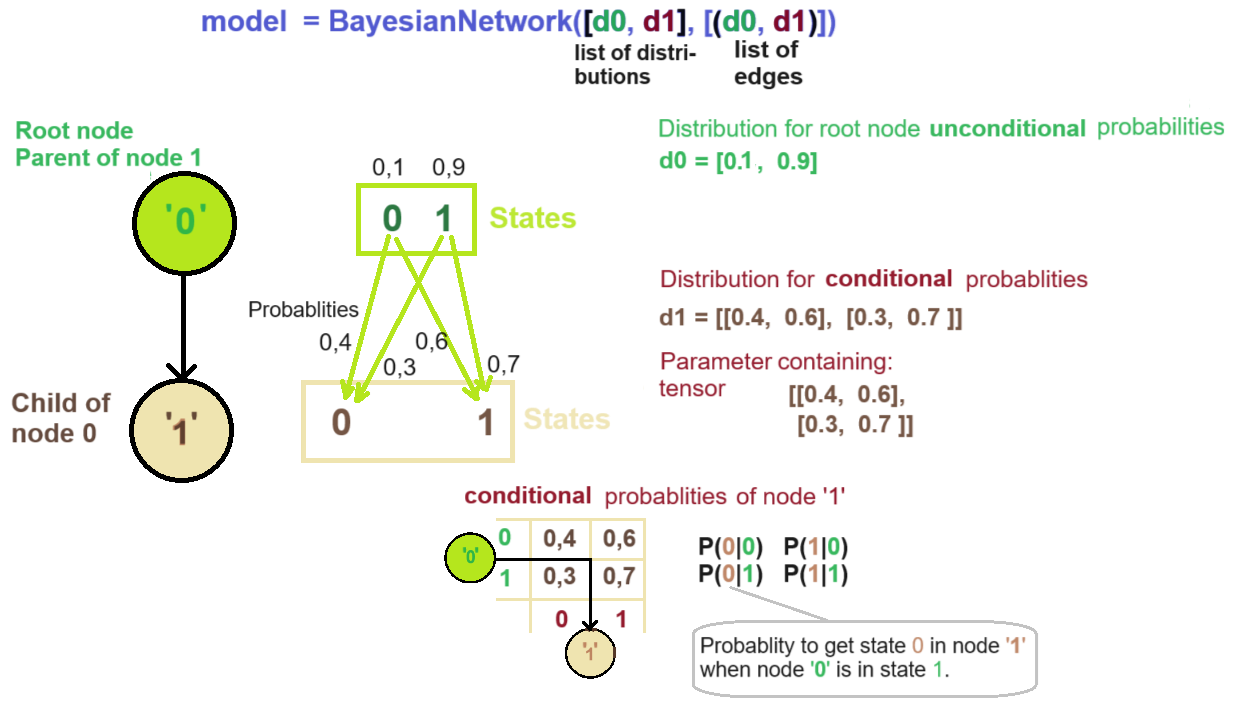

In [2]:
# MODEL DEFINITION
# Probability distributions of each node are given:
d0 = Categorical([[0.1, 0.9]])
d1 = ConditionalCategorical([[[0.4, 0.6], [0.3, 0.7]]])
model0 = BayesianNetwork([d0, d1], [(d0, d1)])               # The model is 'baked' here
#                         nodes       edges                           

In [3]:
# PRINT NODE DISTRIBUTIONS 
# Unconditional probability distribution of node d0 for state values 0 and 1
print(model0.distributions[0].probs[0])  
print(model0.distributions[0].probs[0].numpy() )
print(model0.distributions[0].probs[0][1].numpy() )
print()
# Conditional probability distribution of node d1 for state values 0 and 1
print(model0.distributions[1].probs[0])  
print(model0.distributions[1].probs[0][1].numpy() )
print(model0.distributions[1].probs[0][1][0].numpy() )

tensor([0.1000, 0.9000])
[0.1 0.9]
0.9

Parameter containing:
tensor([[0.4000, 0.6000],
        [0.3000, 0.7000]])
[0.3 0.7]
0.3


In [33]:
# PREDICTIONS
# Write the known node state values to the tenssor and mark the unknowns with -1.
# Each row represents one network state.

#                   d0  d1 
X0 = torch.tensor([[-1, -1],
                   [-1,  0]])                  
                                                                 
# Forming a mask tensor from X0 for predictions
X0_masked = torch.masked.MaskedTensor(X0, mask = X0 >= 0)
print('        d0  d1')
print(model0.predict(X0_masked))   
# The state values missing in X0 are replaced with the most probable prediction values.
# The vertical column shows the states of one node in each of the different states of the network.
# One row represents one state of the network with known and predicted node values.
#print()

        d0  d1
tensor([[1, 1],
        [1, 0]])


In [5]:
# Probabilities of the above network states (lines) from all network states
model0.probability(model0.predict(X0_masked))

tensor([0.6300, 0.2700])

In [6]:
# PROBABILITIES FOR EACH NODE TO BE IN STATE 0 OR 1.
# Each node d0, d1 has its own tensor.
# Each row represents one state of the network
# The first number in the list is the probability of 0 and the second number is the
# probability of 1 (row sum is 1).
print(round((0.9*0.3)/(0.9*0.3 + 0.1*0.4),4))  # The probability that d0=1 when we know that d1=0.
print('           P(0)    P(1)')
model0.predict_proba(X0_masked) 

0.871
           P(0)    P(1)


[tensor([[0.1000, 0.9000],
         [0.1290, 0.8710]]),
 tensor([[0.3100, 0.6900],
         [1.0000, 0.0000]])]

==========================================================================================

### 2.  Network of three nodes
Nodes A and B are root nodes with their **a priori** probablity distributions and node C has a **conditional** probablity distribution depending on the states of A and B.

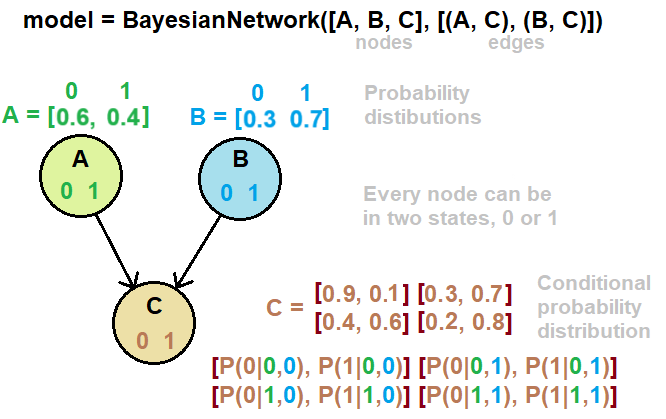

In [7]:
# MODEL DEFINITION
A = Categorical([[0.6, 0.4]])                 # Unconditional probabilities for states 0 and 1
B = Categorical([[0.3, 0.7]])                 # Unconditional probabilities for states 0 and 1
# The probabilities of node C for states 0 and 1 depend on the states of A and B  
C_probs = numpy.array([[
     [[0.9, 0.1], [0.3, 0.7]], 
     [[0.4, 0.6], [0.2, 0.8 ]],
     ]])  
# Interpretation: 
#  [P(0|00), P(1|00)],  [P(0|01), P(1|01)]
#  [P(0|10), P(1|10)],  [P(0|11), P(1|11)]
# In each bracket  P(0|..) + P(1|..) = 1    
# We can see that the value 1 in A and B contribute to the probability of 1 for C,
# node B a little more strongly.
C = ConditionalCategorical(C_probs)            # Conditional probability distribution of node C

model = BayesianNetwork([A, B, C], [(A, C), (B, C)]) 
#                         nodes          edges
# The probability distributions for state values 0 and 1. Each node has its own tensor.
print(model.distributions[0].probs[0])  
print(model.distributions[1].probs[0])  
print(model.distributions[2].probs[0])
print(model.distributions[2].probs[0][1][0].numpy() )
print(model.distributions[2].probs[0][1][0][1].numpy() )

tensor([0.6000, 0.4000])
tensor([0.3000, 0.7000])
Parameter containing:
tensor([[[0.9000, 0.1000],
         [0.3000, 0.7000]],

        [[0.4000, 0.6000],
         [0.2000, 0.8000]]], dtype=torch.float64)
[0.4 0.6]
0.6


In [8]:
# MARK KNOWN AND UNKNOWN NODE VALUES
# Unknowns are marked with -1. Each line represents one network state.
# In the upper state, all states are unknown.
# In the lower state it is known that B=1.
#                   A   B   C
X = torch.tensor([[-1, -1, -1],
                  [-1,  1, -1]])                  
                                                  
# Forming a mask tensor from X for predictions
X_masked = torch.masked.MaskedTensor(X, mask = X >= 0)

# PREDICTIONS for both network states
print('         A  B  C')
model.predict(X_masked)   # In X, the missing state values are replaced with the most
# probable prediction values.
# One row represents one state of the network.
# In the vertical column there are the states of one node in both different network states.


         A  B  C


tensor([[0, 1, 1],
        [0, 1, 1]])

In [9]:
# How likely the above state triplet A=0, B=1, C=1 is?
print(model.probability(model.predict(X_masked)) ) 
P1 =  0.6*0.7*0.7                  # = 0.294  =  P(A=0)*P(B=1)*P(C=1|01) 
print(P1)

tensor([0.2940, 0.2940])
0.294


In [10]:
# PROBABILITIES FOR EACH NODE TO BE IN STATE 0 OR 1.
# Each node A, B, C has its own tensor.
# The first row in each tensor represents the first network state probabilities
# The second row in each tensor represents the second  network state probabilities
# The first number is the probability of 0 and the second number is the probability of 1.
print('           P(0)     P(1)      A B C')
model.predict_proba(X_masked)
#print('P(C=0) =',0.6*0.3*0.9 + 0.6*0.7*0.3 + 0.4*0.3*0.4 + 0.4*0.7*0.2)   # = 0.392

           P(0)     P(1)      A B C


[tensor([[0.6000, 0.4000],
         [0.6000, 0.4000]]),
 tensor([[0.3000, 0.7000],
         [0.0000, 1.0000]]),
 tensor([[0.3920, 0.6080],
         [0.2600, 0.7400]])]

In [11]:
# For Node C, the probabilities of C=0 calculated in both states of the network
# (Lowest tensor, left numbers)
print('P(C=0) =', 0.6*0.3*0.9 + 0.6*0.7*0.3 + 0.4*0.3*0.4 + 0.4*0.7*0.2)
print('P(C=0|B=1) =', 0.6*0.0*0.9 + 0.6*1.0*0.3 + 0.4*0.0*0.4 + 0.4*1.0*0.2)
print('We can see that, if we know that B=1, it lowers the probability of C being at 0')

P(C=0) = 0.392
P(C=0|B=1) = 0.26
We can see that, if we know that B=1, it lowers the probability of C being at 0


In [12]:
# For Node C, the probabilities of C=1 calculated in both states of the network
# (Lowest tensor, right numbers)
print('P(C=1) =', 0.6*0.3*0.1 + 0.6*0.7*0.7 + 0.4*0.3*0.6 + 0.4*0.7*0.8)
print('P(C=1|B=1) =', 0.6*0.0*0.1 + 0.6*1.0*0.7 + 0.4*0.0*0.6 + 0.4*1.0*0.8)
print('That is, if we know that B=1, it increases the probability of C being in 1')

P(C=1) = 0.608
P(C=1|B=1) = 0.74
That is, if we know that B=1, it increases the probability of C being in 1


In [13]:
# Taking a value out of the Torch tensor
print(round(torch.tensor([0.0243]).item(), 4))
print()
print(torch.tensor([[0.2600, 0.7400]]).numpy()[0])
print(torch.tensor([[0.2600, 0.7400]]).numpy()[0][0])
print(torch.tensor([[0.2600, 0.7400]]).numpy()[0][1])
print()

0.0243

[0.26 0.74]
0.26
0.74



==========================================================================================
### 3.  XOR gate 
Exclusive OR 'either or' gives for node C value 1 only if the the states of A and B are different i.e. 0 1 or 1 0.

In [14]:
A = Categorical([[0.5, 0.5]])
B = Categorical([[0.5, 0.5]])
C_probs = numpy.array([[
     [[1.0, 0.0], [0.0, 1.0]], 
     [[0.0, 1.0], [1.0, 0.0 ]],
     ]])  
#  [P(0|00), P(1|00)],  [P(0|01), P(1|01)]
#  [P(0|10), P(1|10)],  [P(0|11), P(1|11)] 
#  Each bracket is for C [P(0), P(1)] and so  [P(0|..) + P(1|..)] = 1
C = ConditionalCategorical(C_probs) 

model1 = BayesianNetwork([A, B, C], [(A, C), (B, C)])


In [15]:
# The known values for each node are marked in the tensor and the unknown values
# are marked with -1. Each row represents one individual network state to predict.
#                   A  B   C

X1 = torch.tensor([[0, 0, -1],
                   [0, 1, -1],
                   [1, 0, -1],
                   [1, 1, -1],
                   [0, -1, 0],
                   [0, -1, 1],
                   [1, -1, 0],
                   [1, -1, 1],
                   [-1, -1, 0],
                 ])   

    
# Form a mask tensor from X for predictions
X1_masked = torch.masked.MaskedTensor(X1, mask = X1 >= 0)

In [16]:
# PREDICTION 
# The different states of the network supplemented with predictions.
print('         A  B  C')
model1.predict(X1_masked)  # In X, the missing state values are replaced with the most
# probable prediction values.
# One row represents one state of the network.
# In the vertical column there are the states of one node in different network states.


         A  B  C


tensor([[0, 0, 0],
        [0, 1, 1],
        [1, 0, 1],
        [1, 1, 0],
        [0, 0, 0],
        [0, 1, 1],
        [1, 1, 0],
        [1, 0, 1],
        [0, 0, 0]])

In [17]:
# How likely is each state triplet above?
print(model1.probability(model1.predict(X1_masked)) ) 

tensor([0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500, 0.2500])


In [18]:
# PROBABILITIES FOR EACH NODE TO BE IN STATE 0 OR 1.
# Each node, A, B, C, has its own tensor.
# The same row in each node's tensor is related to the same state of the network
# The first number in the row is the probability of 0 and the second number is the probability of 1.
# For example, the last row of each tensor represents the same network state A=0, B=0, C=0.
# Node C is in this state with probability 1 because it is set there,
# but states A and B have a probability of 0.5 to be in either state (as long as they are
# in the same state)
print('           P(0)    P(1)')
model1.predict_proba(X1_masked)

           P(0)    P(1)


[tensor([[1.0000, 0.0000],
         [1.0000, 0.0000],
         [0.0000, 1.0000],
         [0.0000, 1.0000],
         [1.0000, 0.0000],
         [1.0000, 0.0000],
         [0.0000, 1.0000],
         [0.0000, 1.0000],
         [0.5000, 0.5000]]),
 tensor([[1.0000, 0.0000],
         [0.0000, 1.0000],
         [1.0000, 0.0000],
         [0.0000, 1.0000],
         [1.0000, 0.0000],
         [0.0000, 1.0000],
         [0.0000, 1.0000],
         [1.0000, 0.0000],
         [0.5000, 0.5000]]),
 tensor([[1., 0.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.]])]

==========================================================================================
### 4. Node B has three different states
The probability distribution of C is defined so that C=1 when the sum of the state values of A and B is 2 or 3 (0+2, 1+1 or 1+2) and C=0 otherwise.

Dim ABC =2x3x2

In [19]:
A = Categorical([[0.5, 0.5]])                      # Probabilities for states 0 and 1
B = Categorical([[0.3, 0.4, 0.3]])                 # Probabilities for states 0,1 and 2
C_probs = numpy.array([[
     [[1.0, 0.0], [1.0, 0.0], [0.0, 1.0]], 
     [[1.0, 0.0], [0.0, 1.0], [0.0, 1.0]],
     ]])  
#  [P(0|00), P(1|00)],  [P(0|01), P(1|01)],  [P(0|02), P(1|02)]
#  [P(0|10), P(1|10)],  [P(0|11), P(1|11)],  [P(0|12), P(1|12)]
# In every bracket [P(0), P(1)] and so  [P(0|..) + P(1|..)] = 1
C = ConditionalCategorical(C_probs) 

model2 = BayesianNetwork([A, B, C], [(A, C), (B, C)])   

In [20]:
# Mark known nodes with their values and unknown ones with -1.
# Each row represents one network state to predict.
#                   A  B   C
X2 = torch.tensor([[0, 0, -1],
                   [0, 1, -1],
                   [0, 2, -1],
                   [1, 0, -1],
                   [1, 1, -1],
                   [1, 2, -1],
                   [0, -1, 0],
                   [0, -1, 1],
                   [1, -1, 0],
                   [1, -1, 1],
                   [-1, -1, 0],
                 ])            

# Mask tensor for predictions
X2_masked = torch.masked.MaskedTensor(X2, mask = X2 >= 0)

In [21]:
# PREDICTION 
print('         A  B  C')
model2.predict(X2_masked)   # Missing values of X are replaced with the most likely predictions.
# The vertical column shows the states of one node in each different state of the network.
# The horizontal line shows one state of the network.

         A  B  C


tensor([[0, 0, 0],
        [0, 1, 0],
        [0, 2, 1],
        [1, 0, 0],
        [1, 1, 1],
        [1, 2, 1],
        [0, 1, 0],
        [0, 2, 1],
        [1, 0, 0],
        [1, 1, 1],
        [0, 0, 0]])

In [22]:
# How likely is each state triplet above?
print(model2.probability(model2.predict(X2_masked))) 

tensor([0.1500, 0.2000, 0.1500, 0.1500, 0.2000, 0.1500, 0.2000, 0.1500, 0.1500,
        0.2000, 0.1500])


In [23]:
# PROBABILITIES FOR EACH NODE TO BE IN STATE 0 OR 1 IN PREFERRED NETWORK STATES
# Each node, A, B, C, has its own tensor.
# The first number in the list is the probability of 0 and the second is the probability of 1.
# The same row in each node's tensor is related to the same state of the network.
# For example, the last row of each tensor represents the same network situation A=0, B=0, C=0. 
# Node C is in this state with probability 1 because it is set so. 
print('           P(0)    P(1)     P(2)')
model2.predict_proba(X2_masked)

           P(0)    P(1)     P(2)


[tensor([[1.0000, 0.0000],
         [1.0000, 0.0000],
         [1.0000, 0.0000],
         [0.0000, 1.0000],
         [0.0000, 1.0000],
         [0.0000, 1.0000],
         [1.0000, 0.0000],
         [1.0000, 0.0000],
         [0.0000, 1.0000],
         [0.0000, 1.0000],
         [0.7000, 0.3000]]),
 tensor([[1.0000, 0.0000, 0.0000],
         [0.0000, 1.0000, 0.0000],
         [0.0000, 0.0000, 1.0000],
         [1.0000, 0.0000, 0.0000],
         [0.0000, 1.0000, 0.0000],
         [0.0000, 0.0000, 1.0000],
         [0.4286, 0.5714, 0.0000],
         [0.0000, 0.0000, 1.0000],
         [1.0000, 0.0000, 0.0000],
         [0.0000, 0.5714, 0.4286],
         [0.6000, 0.4000, 0.0000]]),
 tensor([[1., 0.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.]])]

=============================================================================================

### 5. Node C has three different states
Let's define the probability distribution of C so that C gets the value that comes as the sum of the values of A and B: 0+0=0, 0+1=1+0=1, 1+1=2

In [24]:
A = Categorical([[0.4, 0.6]])             # Probabilities for states 0 and 1
B = Categorical([[0.5, 0.5]])             # Probabilities for states 0 and 1
# Node C can be in three different states 0, 1 or 2   
C_probs = numpy.array([[
     [[1.0, 0.0, 0.0], [0.0, 1.0, 0.0]], 
     [[0.0, 1.0, 0.0], [0.0, 0.0, 1.0]]
     ]])  
#  [P(0|00), P(1|00), P(2|00)],  [P(0|01), P(1|01), P(2|01)]
#  [P(0|10), P(1|10), P(2|10)],  [P(0|11), P(1|11), P(2|11)]
#  [P(0|..) + P(1|..) + P(2|..)] = 1
C = ConditionalCategorical(C_probs) 

model3 = BayesianNetwork([A, B, C], [(A, C), (B, C)]) 

In [25]:
# Mark known nodes with their values and unknown ones with -1.
# Each row represents one network state to predict.
#                   A  B   C
X3 = torch.tensor([[0, 0, -1],
                   [0, 1, -1],
                   [1, 0, -1],
                   [1, 1, -1],
                   [0, -1, 0],
                   [0, -1, 1],
                   [1, -1, 1],
                   [1, -1, 2],
                   [-1, -1, 0],
                   [-1, -1, 1],
                   [-1, -1, 2],
                 ])            

# Mask tensor 
X3_masked = torch.masked.MaskedTensor(X3, mask = X3 >= 0)

In [26]:
# ENNUSTE 
print('         A  B  C')
model3.predict(X3_masked)   # Missing values of X are replaced with the most likely predictions.
# The vertical column shows the states of one node in each different state of the network.
# The horizontal line shows one state of the network.

         A  B  C


tensor([[0, 0, 0],
        [0, 1, 1],
        [1, 0, 1],
        [1, 1, 2],
        [0, 0, 0],
        [0, 1, 1],
        [1, 0, 1],
        [1, 1, 2],
        [0, 0, 0],
        [1, 0, 1],
        [1, 1, 2]])

In [27]:
# # How likely is each state triplet above?
print(model3.probability(model3.predict(X3_masked)) ) 

tensor([0.2000, 0.2000, 0.3000, 0.3000, 0.2000, 0.2000, 0.3000, 0.3000, 0.2000,
        0.3000, 0.3000])


In [28]:
# PROBABILITIES FOR EACH NODE TO BE IN STATE 0 OR 1.
# Each node, A, B, C, has its own tensor.
# The same row in each node's tensor is related to the same state of the network.
# The first number in the row is the probability of 0 and the second is the probability of 1.
print('           P(0)    P(1)')
model3.predict_proba(X3_masked)

           P(0)    P(1)


[tensor([[1.0000, 0.0000],
         [1.0000, 0.0000],
         [0.0000, 1.0000],
         [0.0000, 1.0000],
         [1.0000, 0.0000],
         [1.0000, 0.0000],
         [0.0000, 1.0000],
         [0.0000, 1.0000],
         [1.0000, 0.0000],
         [0.4000, 0.6000],
         [0.0000, 1.0000]]),
 tensor([[1.0000, 0.0000],
         [0.0000, 1.0000],
         [1.0000, 0.0000],
         [0.0000, 1.0000],
         [1.0000, 0.0000],
         [0.0000, 1.0000],
         [1.0000, 0.0000],
         [0.0000, 1.0000],
         [1.0000, 0.0000],
         [0.6000, 0.4000],
         [0.0000, 1.0000]]),
 tensor([[1., 0., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 0., 1.],
         [1., 0., 0.],
         [0., 1., 0.],
         [0., 1., 0.],
         [0., 0., 1.],
         [1., 0., 0.],
         [0., 1., 0.],
         [0., 0., 1.]])]

==========================================================================================
### 6. The value of node D depends on three nodes A, B and C



In [29]:
# Nodes are defined by their probability distributions
A = Categorical([[0.5, 0.5]])        # Priori probabilities for states 0 and 1
B = Categorical([[0.5, 0.5]])        # Priori probabilities for states 0 and 1
C = Categorical([[0.5, 0.5]])        # Priori probabilities for states 0 and 1

# Conditional probabilities for node D are defined so that only 010 and 101 give D the value 1
D_probs = numpy.array([[
    [[[1.0, 0.0], [1.0, 0.0]], 
     [[0.0, 1.0], [1.0, 0.0]]],
    
    [[[1.0, 0.0], [0.0, 1.0]], 
     [[1.0, 0.0], [1.0, 0.0]]]
    ]])  
D = ConditionalCategorical(D_probs) 

# 3D tensor interpretation: P(0) on the left, P(1) on the right and their sum is 1
# Front face 0YZ: Y-down, Z-right
# { [P(0|000), P(1|000)],  [P(0|001), P(1|001)]
#   [P(0|010), P(1|010)],  [P(0|011), P(1|011)]  }

# Back face 1YZ:     Y-down,   Z-right 
# { [P(0|100), P(1|100)],  [P(0|101), P(1|101)]
#   [P(0|110), P(1|110)],  [P(0|111), P(1|111)]  }
    
# In the above distribution of D, only A=0,B=1,C=0 and A=1,B=0,C=1 give D state value 1.
model4 = BayesianNetwork([A, B, C, D], [(A, D), (B, D), (C, D)])
#                            nodes               edges               

In [30]:
# Mark known nodes with their values and unknown ones with -1.
# Each row represents one network state to predict D.
#                   A  B  C   D
X4 = torch.tensor([[0, 0, 0, -1],
                   [0, 1, 0, -1],
                   [1, 0, 0, -1],
                   [1, 1, 0, -1],
                   [0, 0, 1, -1],
                   [0, 1, 1, -1],
                   [1, 0, 1, -1],
                   [1, 1, 1, -1],
                    ])
                              
# mask tensor 
X4_masked = torch.masked.MaskedTensor(X4, mask = X4 >= 0) 
#print(X4_masked)

# PREDICTION 
print('         A  B  C  D')
model4.predict(X4_masked)   # Missing values of X are replaced with the most likely predicted values.
# The vertical column shows the states of one node in each different state of the network.
# The horizontal line shows one state of the network.

         A  B  C  D


tensor([[0, 0, 0, 0],
        [0, 1, 0, 1],
        [1, 0, 0, 0],
        [1, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 1, 1, 0],
        [1, 0, 1, 1],
        [1, 1, 1, 0]])

In [31]:
# The probabilities of above states
print(model4.probability(model4.predict(X4_masked)) ) 

tensor([0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250])


In [32]:
# PROBABILITIES FOR EACH NODE TO BE IN STATE 0 OR 1.
# Each node, A, B, C, D has its own tensor.
# The same row in each node's tensor is related to the same state of the network.
# The first number in the row is the probability of 0 and the second is the probability of 1.
print('           P(0)    P(1)')
model4.predict_proba(X4_masked)

           P(0)    P(1)


[tensor([[1., 0.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [0., 1.]]),
 tensor([[1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.],
         [1., 0.],
         [0., 1.]]),
 tensor([[1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [0., 1.],
         [0., 1.],
         [0., 1.]]),
 tensor([[1., 0.],
         [0., 1.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [1., 0.],
         [0., 1.],
         [1., 0.]])]

Heikki Miettinen 2024